In [151]:
from typing import Tuple, List
from collections import defaultdict
import seaborn as sns
import numpy as np
import pandas as pd
import os

In [187]:
class Runlog:
    """
    Read logs for a given problem across several searches
    """
    def __init__(self, problem: str, searches: List, benchmarks=None, ignore=None):
        self.problem = problem
        self.searches = searches
        self.benchmarks = benchmarks
        self.log_dirs= os.listdir(f"runs/{algo}_{optimizer}/")
    
    @property
    def data(self):
        df = read_run_logs(problem=self.problem, search=self.searches[0], target="new_evaluations")
        for search in self.searches[1:]:
            df = df.append(read_run_logs(problem=self.problem, search=search, target="new_evaluations"))
        return df
    
    @staticmethod
    def pick_relative(x, eps=0.01):
        """
        Pick by relative improvement; Pick longer if better by 'eps', break if not
        """
        x = x.copy()
        if len(x) == 1:
            return(x)
        x['relative_improvement'] = x['in'] - x['in'].shift(1, fill_value=0)
        for ix, rw in x.iterrows():
            if (rw['relative_improvement'] > eps):
                use_ix = ix
            else:
                break
        return use_ix

    def pick_final_expression(self, method = "best"):
        """
        Pick final expression on "in" data
        :method: either "relative", "shortest" or "best"
        """
        df = self.data.copy()
        df = df[df['expression'].str.contains(',')]
        df = df[df.endresult]
        df = df.pivot_table(index=["run", "task", "gen", "length", "problem", "search", "expression"], columns="inout", values="score")
        df = df.reset_index()
        if method == "shortest":
            out = df[df.groupby("run")['length'].transform(min) == df['length']]
        elif method == "relative":
            out = df.loc[[pick_relative(group) for name, group in fdf.groupby('run')]]
        else:
            out = df[df.groupby("run")['in'].transform(max) == df['in']]
        return out
    
    def get_benchmark_performances(self):
        df = self.data[self.data['expression'].isin(self.benchmarks)]
        df = df.pivot_table(index=["run", "task","problem", "search", "expression"], columns="inout", values="score")
        df = df.reset_index()
        df = df[["task", "problem", "expression", "in", "out"]]
        df.drop_duplicates(inplace=True)
        return(df)
        

def read_run_logs(problem:str, search: str, target: str):
    """
    Read all log-files fobestr a given problem-search combination
    """
    log_dir = f"runs/{problem}_{search}/"
    dirs = [os.path.join(log_dir, f) for f in os.listdir(log_dir)]
    df = pd.read_csv(f"{dirs[0]}/{target}.csv", sep=";",nrows=0)
    for dir in dirs: 
        df = df.append(pd.read_csv(f"{dir}/{target}.csv", sep=";"))
    df['problem'] = problem
    df['search'] = search
    return df



In [189]:
benchmarks = ["sklearn_default", "mlr_default", "symbolic_best"]
log = Runlog('svm',  ["mupluslambda", "random_search", "True"], benchmarks=benchmarks)
df = log.pick_final_expression('relative')


inout,task,problem,search,in,out
155,16,svm,random_search,0.8975,0.9977
55,18,svm,mupluslambda,0.8899,0.9642
107,15,svm,mupluslambda,0.9099,0.9816
27,3,svm,random_search,0.9017,0.9132
35,3,svm,random_search,0.8999,0.9568
33,3,svm,random_search,0.8899,0.9641
21,16,svm,random_search,0.8895,0.9981
45,3,svm,mupluslambda,0.8899,0.9641
45,3,svm,mupluslambda,0.8899,0.9641
79,14,svm,random_search,0.9009,0.9944


In [198]:
cols = ["task", "problem", "search", "in", "out"]
df = log.pick_final_expression('relative')[cols]
bdf = log.get_benchmark_performances().rename(columns={"expression":"search"})[cols]
df = df.append(bdf)
df.groupby("search")[["in", "out"]].agg([np.mean, np.median]) 

in                out         
                     mean   median      mean   median
search                                               
mlr_default      0.965774  0.97905  0.359338  0.07950
mupluslambda     0.894900  0.88990  0.968500  0.96415
random_search    0.896567  0.89870  0.970717  0.97925
sklearn_default  0.965774  0.97905  0.946495  0.95015
symbolic_best    0.965774  0.97905  0.977860  0.98160

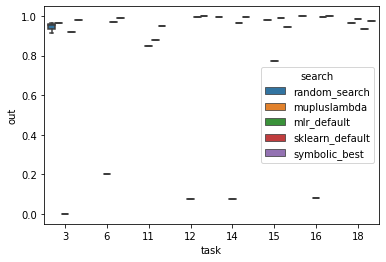

In [196]:
sns.boxplot(data=df, x="task", y="out", hue = "search")

# Symbolic Defaults by 'complexity' of expression
In this notebook we take a look at the results of running the script at its default settings, this means:
 - evaluation across all tasks
 - recording the pareto front of symbolic defaults after each search
 - evaluating in-sample and out-of-sample performance of those dynamic defaults, as well as some pre-defined ones
 
**note:** The console cut off results for the first few tasks, so I am rerunning those now.

For each task we will extract:
 - the number of generations optimization ran for (max=200)
 - max length expression
 - in and out of sample performance for length 1, 2 and 3 expression

For each task save the benchmark results. We also save results for length 1, 2 and 3 solutions as well as the best one found (that may be longer). Specifically we record:
 - best in_sample performance at length 1, 2, 3
 - best in_sample performance for any length
 - average out_sample performance by length for length 1, 2, 3
 - average out_sample performance for the longest (i.e. best in-sample score) solution(s).

## Setup
We have experiment data for a set of algorithms and meta-data for the datasets on which the experiments took place.
We use symbolic regression to find an expression for symbolic default values that give good performance across tasks.
Symbolic regression is performed with leave-one-task-out, which means for each algorithm we have multiple searches for a symbolic default, and their performance is recorded for both in-sample (the optimization surface of all-but-one tasks) and out-of-sample (the left out task) performance. Performance here is solely based on surrogate model predictions, no additional experiments have been performed (yet).

In our search, we use NSGA-II selection to perform multi-objective optimization: find the expression with the best performance, while using the fewest number of operators (e.g. `divide`, `multiply`).

### Terms
**Length** of an expression denotes the number of operators in it. A symbolic value is *not* considered an operation.
Consider the following SVM defaults for cost and gamma:
 - `make_tuple`(m, mkd) is length 1.
 - `make_tuple`(m, `truediv`(mkd, xvar)) is length 2.
 - `make_tuple`(16., `truediv`(mkd, xvar)) is length 2.

The **final** solution refers to the symbolic default with the highest in-sample score for a task (regardless of its length). This means for each task there is *at least* one final solution, but there may be more and they are not of a specific length.


The **baseline** solutions are typically the default hyperparameter settings of mlr, scikit-learn, or both.

---

We read all the logs, because some logs are incomplete we have to explicitly give the name of the baselines (this will be fixed for future runs).

In [ ]:
traces = {}

In [ ]:
# Here we analyze the random forest
alg = 'rf'

import os
baselines = dict(
    glmnet=["mlr_default", "sklearn_default"],
    kerasff=["initial_values"],
    knn=["mlr_default"],
    rf=["mlr_default"],
    rpart=["mlr_default"],
    svm=["sklearn_scale", "symbolic_best", "skearn_default", "mlr_default" , "const"],
)
dir_ = "runs/running"
for file in os.listdir(dir_):
    if file.endswith('.log') and alg in file and ('_0.log' in file or '_1.log' in file):
        print(file)
        baseline = []
        for method, bls in baselines.items():
            if method in file:
                baseline = bls
        traces[file[:-4]] = Trace(os.path.join(dir_, file), benchmarks=baseline, ignore=["const", "symbolic_v2"])

### Optimization
As described before, for each problem we find a symbolic default leaving one task out.
We are interested to see how fast the symbolic regression converges across tasks.

In [ ]:
print("Median number of generations across tasks by problem:")
for log, trace in traces.items():
    print(f"{log: <15} {trace.generations_by_task.median().astype(int):3d}")

In [ ]:
traces = {k :v for (k,v) in traces.items() if k not in ["mlr_glmnet_lisa_ints_0", "mlr_glmnet_lisa_ints_1", "mlr_glmnet_lisa_ints_2"]}

In [ ]:
import matplotlib.pyplot as plt
import math

fig, axes = plt.subplots(math.ceil(len(traces) / 4), 4, sharey=True, figsize=(16, 9))
for ax, (log, trace) in zip(axes.flatten(), traces.items()):
    traces[log].generations_by_task.hist(bins=20, ax=ax)
    ax.set_title(f"{log} ({len(trace.generations_by_task)} tasks)")
    ax.set_ylabel('count')
    ax.set_xlabel('generations')
fig.tight_layout()

The plot above shows a histogram counting the number of generations until stopping. These results were obtained with default setting of early stopping if no improvement was made after 20 generations, with a 200 generation maximum.

### Visualizing optimization traces
The traces contain the full optimization traces inside the trace's **progdf** trace.


In [ ]:
# import seaborn as sns
# sns.lineplot(x='gen', y='max', units='task', estimator=None, data=traces[f'{alg}_gauss24_1eph_d1_2'].progdf)
# sns.lineplot(x='gen', y='max', units='task', estimator=None, data=traces[f'{alg}_gauss24_1eph_d1_2i'].progdf)

### Comparing Expressions
For a given problem, we have a Pareto front of solutions for search (=each left out task).
This Pareto front may contain "twins", multiple solutions which performance equally well and have the same length.
Given that the response surface does not differ *that* much when leaving any particular task out, we hope that the symbolic expressions we find are reasonably consistent across searches.
To have some indication of how consistent the results are, for each problem we find the most frequent solutions of length 1, 2 and 3. We also note the number of hyperparameters for which we aim to find a symbolic default, as we expect this to be correlated to how consistent the solutions are:

In [ ]:
expr_count = pd.DataFrame(np.zeros((5, len(traces))), columns=list(traces), index=[1, 2, 3, "#tasks", "params"])
for log, trace in traces.items():  
    for length, expressions in sorted(trace.expressions.items()):
        if 0 < length < 4:
            m = max(set(expressions), key=expressions.count)
            expr_count.loc[length][log] = expressions.count(m)
            # print(f" Found {len(expressions):3d} expressions of length {length}. Most frequent: {m} ({expressions.count(m)} times)")
            if length == 1:
                expr_count.loc["#tasks"][log] = len(trace.scores) / 2
                expr_count.loc["params"][log] = m.count(',') + 1

We can look at the found expressions per problem:

In [ ]:
a = f'{alg}' # run_one #f"mlr_knn_lisa_gaussian" # run_one
for log, trace in traces.items():
    print(log)
    for length, expressions in sorted(trace.expressions.items()):
        if 0 < length < 4:
            m = max(set(expressions), key=expressions.count)
            expr_count.loc[length][log] = expressions.count(m)
            # print(f" Found {len(expressions):3d} expressions of length {length}. Most frequent: {m} ({expressions.count(m)} times)")
            print(f"Most frequent length {length} solution in Pareto front ({expressions.count(m)} times in {len(trace.scores) // 2} tasks):\n     {m}")

## Expression Quality
The expressions we find also need to be good.
Here we compare the following 'strategies':
 - length-*n*: always pick the best expression of length *n*
 - *final*: always pick the best expression, regardless of length
 - *baseline(s)*: compare it to baselines we defined
 
We want to know (all based on out-of-sample performance):
 - which strategy gives the best solution most often?
 - which strategy experiences the least mean regret?
 - which strategy experiences the least median regret?
 
As mentioned before, there can be "twins" in the Pareto front, which means multiple solutions with equal length have equal in-sample performance.
In this case we average the out-of-sample score of those twins.

#### number of wins:

The following table records the number of times a strategy led to the symbolic expression with the best out-of-sample performance (multiple strategies can be the best each task):

In [ ]:
out_comparisons = pd.DataFrame()
for log, trace in traces.items():
    out_comparisons = out_comparisons.append(trace.comparison.loc['either'].rename(log))
out_comparisons

## Regret
Here we look at the regret for a method compared to the best known performance on the dataset from the random search experiments. Per definition the best score in random search is 1 (normalized score).

#### median regret:
The following table records the median regret for a specific strategy compared to picking the best in hindsight:

In [ ]:
# We only evaluate logs where all tasks in subset have completed

full_tasks = [x[0] for x in traces[f"mlr_{alg}_mupluslambda_0"].scores.index]
subset = set(full_tasks[:20])
subset

In [ ]:
medians = {}
for log, trace in traces.items():
    if (subset.issubset(set([x[0] for x in trace.scores.index]))):
        idx = trace.scores.index.map(lambda idx: idx[1] == "out-sample" and idx[0] in subset)
        medians[log] = [(1 - trace.scores[idx].final).median()]
        
for bl in baselines[alg]:
    medians[bl] = [(1 - traces[f"mlr_{alg}_mupluslambda_0"].scores[idx][bl]).median()]
pd.DataFrame.from_dict(medians,orient='index')

In [ ]:
means = {}
for log, trace in traces.items():
    if (subset.issubset(set([x[0] for x in trace.scores.index]))):
        idx = trace.scores.index.map(lambda idx: idx[1] == "out-sample" and idx[0] in subset)
        means[log] = [(1 - trace.scores[idx].final).mean()]
    
for bl in baselines[alg]:
    means[bl] = [(1 - traces[f"mlr_{alg}_mupluslambda_0"].scores[idx][bl]).median()]
pd.DataFrame.from_dict(means,orient='index')

### Results averaged over replications


In [ ]:
# means
pd.DataFrame.from_dict(means,orient='index').groupby(lambda x: ''.join(i for i in x if not i.isdigit())).mean()

In [ ]:
# medians
pd.DataFrame.from_dict(medians,orient='index').groupby(lambda x: ''.join(i for i in x if not i.isdigit())).mean()

### Sanity Checks
Sometimes out-of-sample performance of a baseline may still be better than that of our solution.
However, in-sample performance of our own solutions should always be better than any baseline.
If that is not the case, this would indicate our search does not explore the space well enough.

In [ ]:
in_sample_comparisons = pd.DataFrame()
for log, trace in traces.items():
    in_sample_comparisons = in_sample_comparisons.append(trace.in_comparison.loc['either'].rename(log))
in_sample_comparisons

In [ ]:
ml = traces['mlr_rf_mupluslambda_2']
rs = traces['mlr_rf_random_search_2']

In [ ]:
ml.scores.head()

### Comparison to random search 
The following provides an overview over scores for different iterations of random search

In [ ]:
rsdf = pd.read_csv("data/mlr_"+alg+"_baselines.csv", index_col=0)
rsdf.iloc[:,1:].apply(np.mean,axis=1)

----
End of notebook - just sketchpad below

In [ ]:
trsdf = rsdf.transpose()
trsdf.index.name = "task"
trsdf.index = pd.Index([int(float(x)) for x in trsdf.index.values])

In [ ]:
import seaborn as sns
df = ml.scores.loc[ml.scores.index.map(lambda idx: idx[1] == "out-sample")]
df.index = pd.Index(df.index.map(lambda idx: idx[0]))
df = df.join(trsdf)

In [ ]:
df = df.loc[:,df.median().sort_values().index]
p = sns.boxplot(data=df.melt(), y = "value", x = "variable")
p.set_xticklabels(p.get_xticklabels(), rotation=45)
plt.show(p)

In [ ]:
################ END OF RELEVANT PARTS #################

In [ ]:
alg = "rf"
run_one = f"mlr_{alg}_mupluslambda_0"
minimum = dict(knn=100, svm=100, glmnet=100, rpart=60, rf=25)
final_scores = pd.DataFrame()
for log, trace in traces.items():
    # Filter out runs with >100 tasks completed:
    if len(trace.scores) / 2 > minimum[alg]:
        out_sampfirst_n_tasksle = trace.scores.index.map(lambda idx: idx[1] == "out-sample")
        log_oos = trace.scores.loc[out_sample].final.rename(log)
        final_scores = final_scores.append(log_oos)
        if log == run_one:
            # contains benchmark scores
            for b in trace.baseline:
                baseline_score = trace.scores.loc[out_sample][b].rename(b)
                final_scores = final_scores.append(baseline_score)
final_scores

In [ ]:
# filter out incomplete tasks:
final = final_scores.loc[:, ~final_scores.isna().any()]
df = final

In [ ]:
run_one="mlr_svm_lisa"
run_two="svm_warm"

In [ ]:
df = df.loc[[run_one, run_two]]

In [ ]:
alone = {k: 0 for k in df.index.values}
shared = {k: 0 for k in df.index.values}

for _, out in df.T.iterrows():
    best = out[out == out.max()].index.values
    if len(best) == 1:
        alone[best[0]] += 1
    else:
        for winner in best:
            shared[winner] += 1

alone = {k: alone[k] for k in sorted(alone)}
shared = {k: shared[k] for k in sorted(shared)}
either = {k: shared[k] + alone[k] for k in sorted({**alone, **shared})}
comparison = pd.DataFrame([alone, shared, either], index=['alone', 'shared', 'either'])
comparison


In [ ]:
df_out = df.T.copy()
df_out['max'] = df_out.max(axis=1)
for col in df_out:
    df_out['d_' + col] = df_out['max'] - df_out[col]
d_cols = [c for c in df_out.columns if c.startswith('d_') and 'max' not in c]
df_out[d_cols].mean()

In [ ]:
df_out[d_cols].median()

In [ ]:
ax = (df.loc[run_one] - df.loc[run_two]).hist(bins=[(f / 40 - 1) for f in range(81)])
ax.set_title(f"Symbolic - Constant | median: {(df.loc[run_one] - df.loc[run_two]).median():.3f}, mean: {(df.loc[run_one] - df.loc[run_two]).mean():.3f}, {df.shape[1]} tasks")
ax.set_ylabel("Count")
ax.set_xlabel("Difference")

In [ ]:
sum((df.loc["mlr_svm_lisa"] - df.loc["svm_cst"]) > 0)

In [ ]:
(df.loc["mlr_svm_lisa"] - df.loc["svm_cst"]).mean()

In [ ]:
rsdf.columns = [(round(float(x)), 'out-sample')  for x in rsdf.columns.values

In [ ]:
df = rsdf.append(final_scores)
df.iloc[:,1:].apply(np.mean,axis=1)

In [ ]:
pdf = df.transpose().melt(var_name="method", value_name="performance")
ax = sns.boxplot(x='method', y='performance', data = pdf)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#### mean regret:
The following table records the mean regret for a specific strategy compared to picking the best in hindsight:

In [ ]:
means = pd.DataFrame([])
for log, trace in traces.items():
    m = trace.d_scores.mean().rename(log)
    means = means.append(m)
means[[c for c in medians.columns if 'd_' in c and c != 'd_max']]

In [98]:
for problem in ["svm"]:
    for search in ["mupluslambda", "random_search", "True"]:
        problem_search_dir = os.path.join("runs", f"{problem}_{search}")   
        for rundir in os.listdir(problem_search_dir):
            eval_file = os.path.join(problem_search_dir, rundir, "evaluations.csv")
            eval_file_new = os.path.join(problem_search_dir, rundir, "new_evaluations.csv")
            with open(eval_file) as old, open(eval_file_new, 'w') as new:
                for line in old.readlines():
                    content = line.split(',')
                    cs, expr_parts = content[:7], content[7:]
                    newsep = ';'.join(cs + [','.join(expr_parts)])
                    new.write(newsep)